In [41]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# set the home directory using absolute path
os.chdir('c:/Users/01eco/Documents/Programming/Python/multisource_ML_research')
pd.set_option("future.no_silent_downcasting", True)
# set random generation seed for torch
torch.manual_seed(42)

In [42]:
# define the hyperparameters of the lstm model
window_length = 10
hidden_size = 128
num_layers=2
dropout_rate = 0.2
learning_rate = 0.001
num_epochs = 50
batch_size = 32

train_balance = 0.8
validation_balance = 1 - train_balance

In [43]:
# define the features to be used to train the lstm model as a list of both vehicle features and eye tracking features
vehicle_features = [
    'Horizontal tangential speed_t0',
    'Tangential speed_t0',
    'Speed/X_t0',
    'Speed/Y_t0',
    'Brake pedal force_t0',
    'Gas pedal_t0',
    'Steering wheel angle_t0'
]

eye_tracking_features = [
    'Data Gaze2D X_t0',
    'Data Gaze2D Y_t0',
    'Velocity_t0',
    'Is_Fixation_t0',
    'Is_Gaze_On_Hazard_t0'
]

# get the number of total features
total_features = len(vehicle_features) + len(eye_tracking_features)
print(total_features)

12


In [44]:
windows = []
targets = []

In [45]:
# define the root folder for the data
data_root = 'data/processed_data/binned_data_1'
bins = os.listdir(data_root)
# iterate through all the bins in the root folder
for b in bins:
    files = os.listdir(f'{data_root}/{b}')
    # iterate through each encounter in the current bin
    for f in files:
        file_path = f'{data_root}/{b}/{f}'
        # open the encounter data into a pandas df
        encounter_df = pd.read_csv(file_path)
        
        # clean the file for True and False values to set them as 1 or 0
        encounter_df = encounter_df.replace({False: 0, True: 1,'False': 0, 'True': 1,'0.0': 0,'1.0': 1})
        # remove rows with N/A values
        encounter_df.dropna(inplace=True)
        # set the collision_flag to the global_collision_flag
        collision_flag = encounter_df['global_collision_flag_t0']

        # there are at least one or two encounters with no data so check for this condition before proceeding
        if encounter_df.shape[0] != 0:
            # collect the data from the encounter based on the selected features
            vehicle_data = encounter_df[vehicle_features]
            eye_data = encounter_df[eye_tracking_features]

            # create scaler based on all data, apply scaler to each set of data, then merge into one dataset
            scaler = StandardScaler()
            all_data = np.hstack([encounter_df[vehicle_features], encounter_df[eye_tracking_features]])
            scaler.fit(all_data)
            
            vehicle_data_normalized = scaler.fit_transform(vehicle_data)
            eye_data_normalized = scaler.fit_transform(eye_data)

            features = np.hstack([vehicle_data_normalized,eye_data_normalized])

            # iterate through encounter_df length
            # apply sliding window technique using window_length parameter
            # range max adjusts encounter length to not pull windows that exceed encounter length
            for w in range(len(encounter_df) - window_length + 1):
                # append a subset of data of length window_length to windows from the feature set and targets from the target set

                # windows will end up with a size that is roughly the same as the encounter length
                # data in windows will be 2D arrays that are window_length * total_features
                windows.append(features[w:(w+ window_length)])
                # targets will end up being a series that is roughly the same as the encounter length
                # data is a set of integers (either 0 or 1) representing no collision or collision respectively by taking the target from the end of the current window to match the window previous
                targets.append(int(collision_flag.iloc[w + window_length - 1]))

In [ ]:
# convert targets to np.array
target_array = np.array(targets)

# attempt to calculate pos_weight based on class balance
unique,counts = np.unique(target_array,return_counts=True)
class_balance = dict(zip(unique,counts))
pos_weight_torch_value = torch.tensor([class_balance[0]/class_balance[1]])

print(int(pos_weight_torch_value))

32


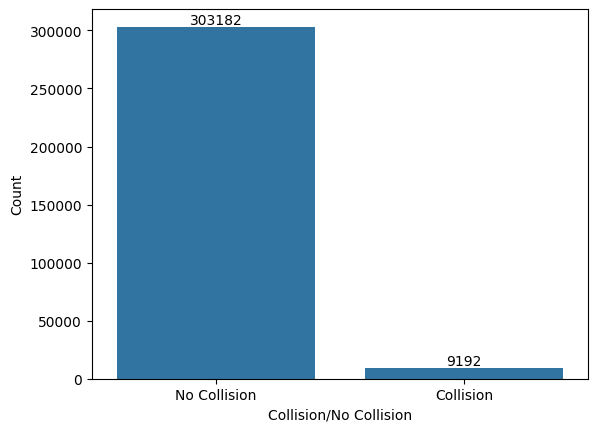

In [47]:
# plot the class balance in the targets array
ax = sns.countplot(x=target_array)
ax.bar_label(ax.containers[0])
plt.xlabel('Collision/No Collision')
plt.ylabel('Count')

plt.xticks([0,1],['No Collision','Collision'])
plt.show()

In [48]:
# convert the windows and targets list to a PyTorch tensor with float32 numbers
windows = torch.FloatTensor(np.array(windows))
targets = torch.FloatTensor(np.array(targets))

In [49]:
total_samples = len(windows)
print(f'Total samples = {total_samples}')

train_size = int(train_balance * total_samples)
validation_size = total_samples - train_size

print(f'Samples for training = {train_size}\nSamples for validation = {validation_size}')

Total samples = 312374
Samples for training = 249899
Samples for validation = 62475


In [50]:
# randomly shuffle indices of in the total samples range
indices = torch.randperm(total_samples)
# train and validation indices are taken using the sizes from previous
train_indices = indices[:train_size]
validation_indices = indices[train_size:]

In [51]:
# pull the data from the window and targets for training and validation using the previously determined indices
train_windows = windows[train_indices]
train_targets = targets[train_indices]
validation_windows = windows[validation_indices]
validation_targets = targets[validation_indices]

In [52]:
# convert data to a torch dataset
train_data = torch.utils.data.TensorDataset(train_windows,train_targets)
validation_data = torch.utils.data.TensorDataset(validation_windows,validation_targets)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=batch_size,shuffle=False)

In [53]:
# get the input size for the network (should be the same as the number of features that are being used)
input_size = windows.shape[2]
print(input_size)

12


In [54]:
# create the stages of the neural network
lstm = nn.LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_first=True,
    dropout=dropout_rate
)

fc1 = nn.Linear(hidden_size,64) # fully connected layer
relu = nn.ReLU() # activation layer
dropout = nn.Dropout(dropout_rate) # dropout layer
fc2 = nn.Linear(64, 1) # fully connected layer

In [55]:
# use gpu if available, otherwise use the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set the device for each stage
lstm = lstm.to(device)
fc1 = fc1.to(device) # fully connected layers
fc2 = fc2.to(device)
relu = relu.to(device) # activation
dropout = dropout.to(device) # dropout

In [56]:
# pos_weight controls the weighting in favour of the positive class
# pos_weight = torch.tensor(32).to(device)
pos_weight = pos_weight_torch_value.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Binary Cross Entropy loss function with the pos_weight, applies sigmoid at the end when calculating loss
params = list(lstm.parameters()) + list(fc1.parameters()) + list(fc2.parameters()) # collect all trainable parameters
optimizer = torch.optim.Adam(params,lr=learning_rate) # use the adam optimizer for the model and set the learning rate, used to update the parameters

In [57]:
metrics_df = pd.DataFrame(columns=['Epoch','Train Loss','Validation Loss','Validation Accuracy','FPR','TPR','ROC-AUC Score'])

In [58]:
# 0: print nothing; 1: print epoch count; 2: print epoch and confusion matrix; 3: print all metrics
debug_status = 3

# iterate for the number of epochs
for epoch in range(num_epochs):
    # set modes to training
    train_loss = 0
    lstm.train()
    fc1.train()
    fc2.train()
    
    # training loop
    for batch_windows, batch_targets in train_loader: # iterate over the batches in train_loader
        batch_windows = batch_windows.to(device)
        batch_targets = batch_targets.to(device)
    
        optimizer.zero_grad() # set gradients to zero to avoid accumulation
        lstm_out, _ = lstm(batch_windows)
        last_timestep = lstm_out[:, -1, :]
        # pass through 2 fully connected layers with ReLU activation layer and dropout
        fc1_out = fc1(last_timestep)
        relu_out = relu(fc1_out)
        dropout_out = dropout(relu_out)
        fc2_out = fc2(dropout_out)
    
        outputs = fc2_out.view(-1)
        loss = criterion(outputs, batch_targets)
    
        loss.backward() # perform backpropagation
        optimizer.step() # update weights
    
        train_loss += loss.item() # update loss
    
    # validation loop to calculate metrics using current training stage
    validation_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    # set modes to validation
    lstm.eval()
    fc1.eval()
    fc2.eval()
    
    with torch.no_grad(): # set to not update parameters
        for batch_windows, batch_targets in validation_loader:
            batch_windows = batch_windows.to(device)
            batch_targets = batch_targets.to(device)
    
            lstm_out, _ = lstm(batch_windows)
            last_timestep = lstm_out[:, -1, :]
            fc1_out = fc1(last_timestep)
            relu_out = relu(fc1_out)
            dropout_out = dropout(relu_out)
            fc2_out = fc2(dropout_out)
    
            outputs = fc2_out.view(-1)
            loss = criterion(outputs, batch_targets)
            validation_loss += loss.item()
    
            predicted = (outputs > 0).int() # use 0 for logits
            correct += (predicted == batch_targets.int()).sum().item()
            total += batch_targets.numel()
    
            # collect predictions and targets calculating metrics
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    
    # compute metrics using scikit learn after the forward pass through the validation stage
    # convert probabilities to binary predictions using a threshold of 0.5
    binary_preds = [1 if p > 0 else 0 for p in all_preds]
    report = classification_report(all_targets, binary_preds, digits=4)
    conf_matrix = confusion_matrix(all_targets, binary_preds)
    fpr, tpr, _ = roc_curve(all_targets, binary_preds)
    
    try:
        roc_auc = roc_auc_score(all_targets, binary_preds)
    except Exception as e:
        roc_auc = None
    
    # print epoch metrics along with additional metrics
    if debug_status >= 1: # print just the epoch count if 1
        print(f'----------------------------- Epoch [{epoch+1}/{num_epochs}] ----------------------------------------')
    if debug_status >= 3: # print all if 3
        print(f'Train Loss: {train_loss/len(train_loader)}')
        print(f'Validation Loss: {validation_loss/len(validation_loader)}')
        print(f'Validation Accuracy: {100 * correct/total}%')
        print(f'Classification Report:\n{report}')
        print(f'False Positive Rate: {fpr[1]}')
        print(f'True Positive Rate: {tpr[1]}')
        print(f'ROC-AUC:{roc_auc}')
    if debug_status >= 2: # print epoch and confusion matrix if 2
        print(f'Confusion Matrix:\n{conf_matrix}')

    metrics_df.loc[len(metrics_df)] = [epoch,train_loss/len(train_loader),validation_loss/len(validation_loader),correct/total,fpr[1],tpr[1],roc_auc]

----------------------------- Epoch [1/50] ----------------------------------------
Train Loss: 0.7053342648146247
Validation Loss: 0.2572990996287196
Validation Accuracy: 94.40736294517806%
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9991    0.9432    0.9704     60626
         1.0     0.3431    0.9724    0.5072      1849

    accuracy                         0.9441     62475
   macro avg     0.6711    0.9578    0.7388     62475
weighted avg     0.9797    0.9441    0.9566     62475

False Positive Rate: 0.056790815821594696
True Positive Rate: 0.9724175229853975
ROC-AUC:0.9578133535819013
Confusion Matrix:
[[57183  3443]
 [   51  1798]]
----------------------------- Epoch [2/50] ----------------------------------------
Train Loss: 0.20949082445941605
Validation Loss: 0.1488770883969335
Validation Accuracy: 96.79391756702681%
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9994    0.967

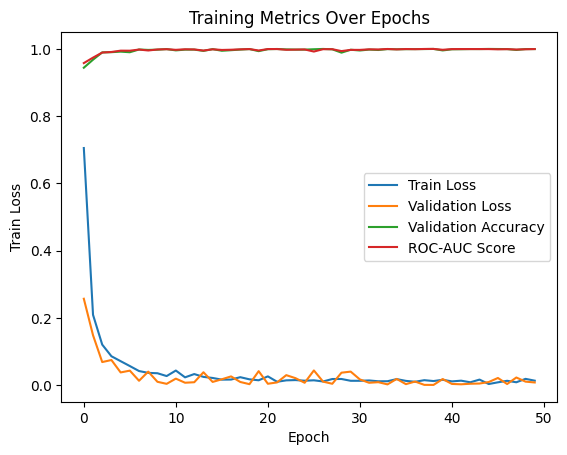

In [59]:
sns.lineplot(data=metrics_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=metrics_df, x='Epoch', y='Validation Loss', label='Validation Loss')
sns.lineplot(data=metrics_df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')
sns.lineplot(data=metrics_df, x='Epoch', y='ROC-AUC Score', label='ROC-AUC Score')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.show()

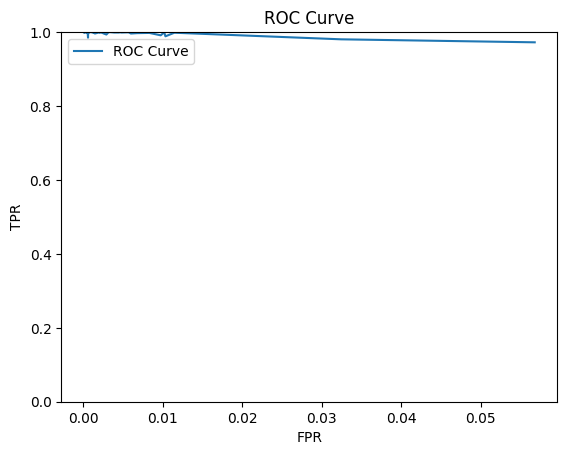

In [60]:
sns.lineplot(data=metrics_df, x='FPR', y='TPR', label='ROC Curve')
plt.title('ROC Curve')
plt.ylim(0, 1)
plt.legend()
plt.show()